Angle between Earth and Mars at 2025-02-22 19:52:30.247: 21.46 degrees
Angle between Jupiter and Saturn 100 years ago (1925-02-22 19:53:07.248): 57.41 degrees


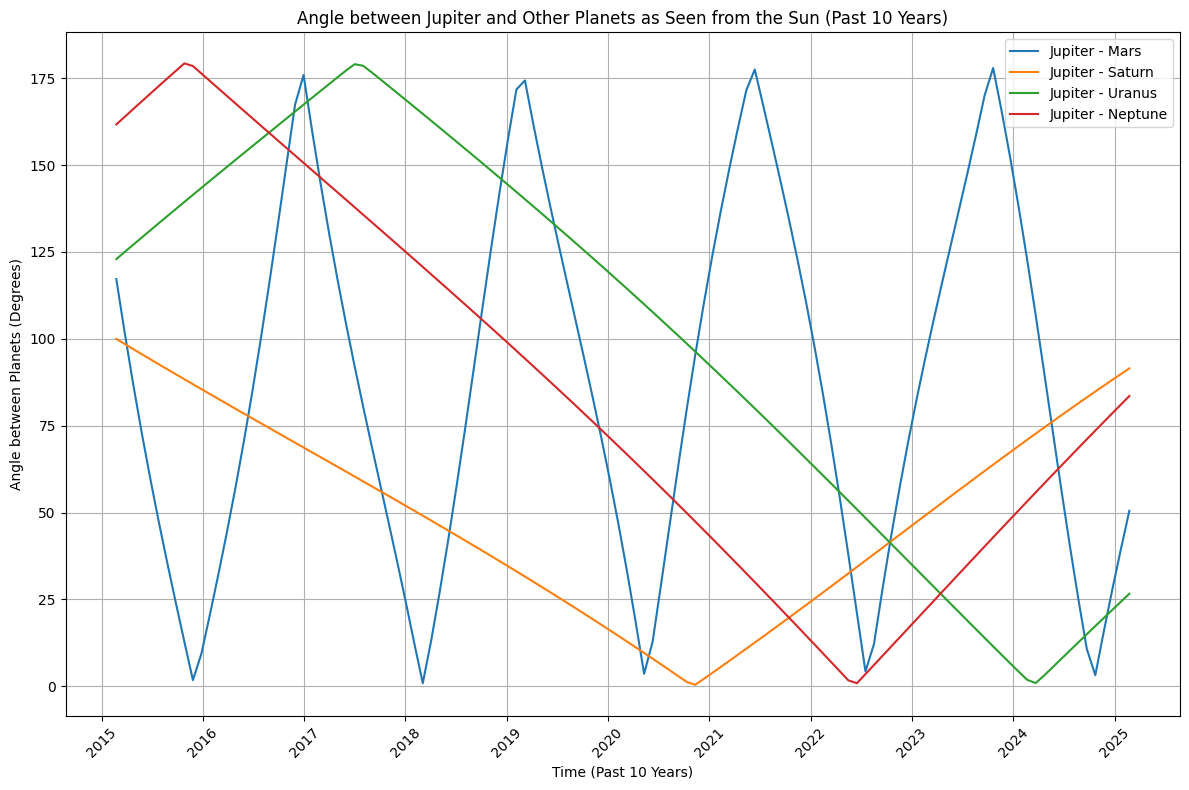

In [339]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_body_barycentric
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_planet_angle(planet1_name, planet2_name, time):
    """
    Calculates the angle between two planets as viewed from the Sun at a given time.

    Parameters:
    planet1_name (str): Name of the first planet (e.g., 'jupiter', 'earth').
    planet2_name (str): Name of the second planet.
    time (astropy.time.Time): Time at which to calculate the angle.

    Returns:
    float: Angle between the two planets in degrees. Returns None if there's an error.
    """
    try:
        # Get barycentric positions of the planets at the given time
        planet1_pos = get_body_barycentric(planet1_name, time)
        planet2_pos = get_body_barycentric(planet2_name, time)

        # Represent positions as vectors from the Sun (assuming Sun is at barycenter for simplicity for angles)
        vector1 = planet1_pos.xyz.value  # Convert to numpy array for vector operations
        vector2 = planet2_pos.xyz.value

        # Calculate the angle between the two vectors using dot product
        dot_product = np.dot(vector1, vector2)
        magn1 = np.linalg.norm(vector1)
        magn2 = np.linalg.norm(vector2)

        if magn1 == 0 or magn2 == 0: # Handle cases where position might be zero (though unlikely for planets)
            return None # Or raise an exception depending on desired behavior

        cos_angle = dot_product / (magn1 * magn2)

        # Ensure cos_angle is within the valid range [-1, 1] due to potential floating point errors
        cos_angle = np.clip(cos_angle, -1.0, 1.0)

        angle_radians = np.arccos(cos_angle)
        angle_degrees = np.degrees(angle_radians)

        return angle_degrees

    except Exception as e:
        print(f"Error calculating angle: {e}")
        return None

def graph_jupiter_angles_past_decade():
    """
    Graphs the angle between Jupiter and each other planet (excluding Jupiter itself)
    over the past 10 years.
    """
    # planets = ['mercury', 'venus', 'earth', 'mars', 'saturn', 'uranus', 'neptune'] # Exclude Jupiter itself
    planets = ['mars', 'saturn', 'uranus', 'neptune'] # Exclude Jupiter itself
    current_time = Time.now()
    start_time = current_time - 10 * u.year

    # Create a time range for the past 10 years (e.g., monthly intervals)
    times = Time(np.linspace(start_time.jd, current_time.jd, 120), format='jd') # Roughly monthly for 10 years

    plt.figure(figsize=(12, 8)) # Adjust figure size as needed

    for planet_name in planets:
        angles = []
        for t in times:
            angle = calculate_planet_angle('jupiter', planet_name, t)
            if angle is not None:
                angles.append(angle)
            else:
                angles.append(np.nan) # Handle potential errors with NaN for plotting

        plt.plot(times.datetime, angles, label=f'Jupiter - {planet_name.capitalize()}') # Use datetime for better x-axis

    plt.xlabel('Time (Past 10 Years)')
    plt.ylabel('Angle between Planets (Degrees)')
    plt.title('Angle between Jupiter and Other Planets as Seen from the Sun (Past 10 Years)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

if __name__ == "__main__":
    # Example usage for querying angle at a specific time:
    time_now = Time.now()
    angle_earth_mars = calculate_planet_angle('earth', 'mars', time_now)
    if angle_earth_mars is not None:
        print(f"Angle between Earth and Mars at {time_now.iso}: {angle_earth_mars:.2f} degrees")

    # Example usage for querying angle at a past time (100 years ago):
    time_past = Time.now() - 100 * u.year
    angle_jupiter_saturn_past = calculate_planet_angle('jupiter', 'saturn', time_past)
    if angle_jupiter_saturn_past is not None:
        print(f"Angle between Jupiter and Saturn 100 years ago ({time_past.iso}): {angle_jupiter_saturn_past:.2f} degrees")

    # Graph the angles for Jupiter and other planets over the past 10 years:
    graph_jupiter_angles_past_decade()


In [261]:
sunspot_data = pd.read_csv("SN_d_tot_V2.0.csv", sep=';', comment='#',
                         names=['Year', 'Month', 'Day', 'Decimal_Year', 'Sunspot_Number',
                                'StdDev', 'Num_Observations', 'Definitive_Provisional'])
sunspot_data[65000:65005]

,Year,Month,Day,Decimal_Year,Sunspot_Number,StdDev,Num_Observations,Definitive_Provisional
65000,1995,12,19,1995.966,0,2.0,10,1
65001,1995,12,20,1995.968,12,2.6,14,1
65002,1995,12,21,1995.971,13,1.6,21,1
65003,1995,12,22,1995.974,13,2.4,13,1
65004,1995,12,23,1995.977,12,7.3,12,1


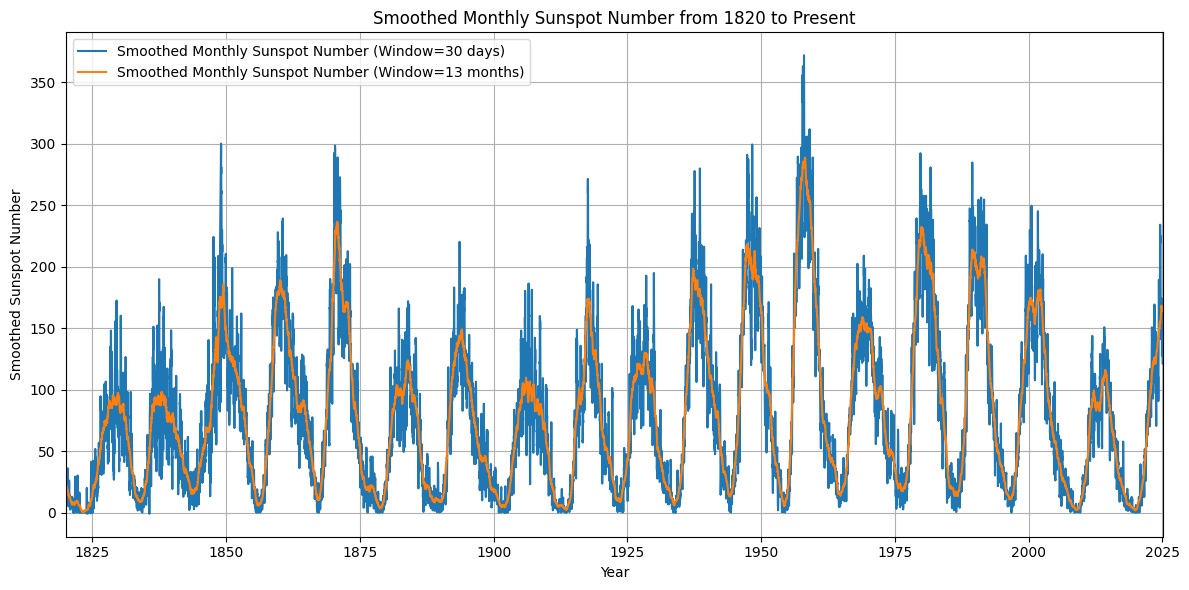

            Year  Month  Day  Decimal_Year  Sunspot_Number  StdDev  \
Date                                                                 
1995-12-19  1995     12   19      1995.966               0     2.0   
1995-12-20  1995     12   20      1995.968              12     2.6   
1995-12-21  1995     12   21      1995.971              13     1.6   
1995-12-22  1995     12   22      1995.974              13     2.4   
1995-12-23  1995     12   23      1995.977              12     7.3   
...          ...    ...  ...           ...             ...     ...   
2025-01-27  2025      1   27      2025.073              54    12.6   
2025-01-28  2025      1   28      2025.075              75    11.8   
2025-01-29  2025      1   29      2025.078              82    10.4   
2025-01-30  2025      1   30      2025.081             106    21.0   
2025-01-31  2025      1   31      2025.084             146    32.1   

            Num_Observations  Definitive_Provisional  \
Date                             

In [352]:
import pandas as pd
import matplotlib.pyplot as plt

def smooth_sunspot_data(daily_sunspot_data, filepath="SN_d_tot_V2.0.csv", smoothing_window=13): # Window of 13 months for smoothing
    """
    Loads daily sunspot data from a CSV, calculates monthly averages,
    applies a moving average smoothing, and returns a DataFrame with
    smoothed monthly sunspot numbers.

    Parameters:
    filepath (str): Path to the CSV file containing daily sunspot data.
    smoothing_window (int): Size of the rolling window for smoothing (in months).

    Returns:
    pandas.DataFrame: DataFrame with columns 'Year', 'Month', 'Day', 'Decimal_Year',
                      'Monthly_Sunspot_Number', 'Smoothed_Sunspot_Number'.
                      Returns None if there's an error loading the data.
    """
    daily_sunspot_data['Sunspot_Number_smoothed_13m'] = daily_sunspot_data['Sunspot_Number'].rolling(window=390, center=True, min_periods=1).mean()
    daily_sunspot_data['Sunspot_Number_smoothed_30d'] = daily_sunspot_data['Sunspot_Number'].rolling(window=30, center=True, min_periods=1).mean()

# Graph the smoothed data from 1950 to present
start_year_plot = 1820
plot_data = sunspot_data[sunspot_data['Year'] >= start_year_plot]

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Decimal_Year'], plot_data['Sunspot_Number_smoothed_30d'], label=f'Smoothed Monthly Sunspot Number (Window={30} days)')
plt.plot(plot_data['Decimal_Year'], plot_data['Sunspot_Number_smoothed_13m'], label=f'Smoothed Monthly Sunspot Number (Window={13} months)')
plt.xlabel('Year')
plt.ylabel('Smoothed Sunspot Number')
plt.title(f'Smoothed Monthly Sunspot Number from {start_year_plot} to Present')
plt.xlim(start_year_plot, plot_data['Decimal_Year'].max()) # Set x-axis limits
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(sunspot_data[65000:])

In [296]:
# Add dates until 2040

arr = sunspot_data[['Year', 'Month', 'Day', 'Decimal_Year']][66109:66474]
brr = sunspot_data[['Year', 'Month', 'Day', 'Decimal_Year']][66140:66474].copy()

brr[['Year', 'Decimal_Year']] += 26
sunspot_data_extended = pd.concat([sunspot_data,brr], ignore_index=True)

for i in range(1,16):
    brr = arr.copy()
    brr[['Year', 'Decimal_Year']] += i + 26
    sunspot_data_extended = pd.concat([sunspot_data_extended,brr], ignore_index=True)
sunspot_data_extended[77000:]

,Year,Month,Day,Decimal_Year,Sunspot_Number,StdDev,Num_Observations,Definitive_Provisional,Sunspot_Number_smoothed_13m,Sunspot_Number_smoothed_30d
77000,2028,10,27,2028.821,NaN,NaN,NaN,NaN,NaN,NaN
77001,2028,10,28,2028.823,NaN,NaN,NaN,NaN,NaN,NaN
77002,2028,10,29,2028.826,NaN,NaN,NaN,NaN,NaN,NaN
77003,2028,10,30,2028.829,NaN,NaN,NaN,NaN,NaN,NaN
77004,2028,10,31,2028.832,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
81441,2040,12,27,2040.988,NaN,NaN,NaN,NaN,NaN,NaN
81442,2040,12,28,2040.990,NaN,NaN,NaN,NaN,NaN,NaN
81443,2040,12,29,2040.993,NaN,NaN,NaN,NaN,NaN,NaN
81444,2040,12,30,2040.996,NaN,NaN,NaN,NaN,NaN,NaN


In [297]:
from itertools import combinations

def add_planet_angles_to_dataframe(df):
    """
    Calculates angles between all unique pairs of planets for each time point
    in the input DataFrame and adds them as new columns.

    Parameters:
    df (pandas.DataFrame): DataFrame with a 'Decimal_Year' column representing time.

    Returns:
    pandas.DataFrame: DataFrame with added columns for planet angles.
    """
    planets = ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
    # planets = ['uranus', 'neptune']
    planet_pairs = list(combinations(planets, 2)) # Get unique planet pairs

    angle_data = []
    for index, row in df.iterrows():
    # for index, row in df[37254:].iterrows():   # start at 1920
    # for index, row in df[75606:].iterrows():  # start at 2025
        if index % 1000 == 0:
            print(index)
        decimal_year = row['Decimal_Year']
        time = Time(decimal_year, format='decimalyear') # Create Time object from decimal year
        month_angles = {}
        for planet1, planet2 in planet_pairs:
            angle = calculate_planet_angle(planet1, planet2, time)
            if angle is not None:
                angle_name = f"{planet1}-{planet2}"
                month_angles[angle_name] = angle
            else:
                angle_name = f"{planet1}-{planet2}"
                month_angles[angle_name] = np.nan # Or some other placeholder for missing angle

        month_angles['Decimal_Year'] = decimal_year # Keep Decimal_Year for merging
        angle_data.append(month_angles)

    angles_df = pd.DataFrame(angle_data)
    merged_df = pd.merge(df, angles_df, on='Decimal_Year', how='left') # Merge based on Decimal_Year
    return merged_df

df_with_angles = add_planet_angles_to_dataframe(sunspot_data_extended.copy())

0


/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 1 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000


In [298]:
# df_with_angles.to_csv("solar_cycles_with_angles.csv", index=False)
df_with_angles[75606:]
# sunspot_data[37254:]
# planets = ['earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
# planet_pairs = list(combinations(planets, 2)) # Get unique planet pairs
# features = [f"{p1}-{p2}" for p1, p2 in planet_pairs]
# df_with_angles[70000:][features]

,Year,Month,Day,Decimal_Year,Sunspot_Number,StdDev,Num_Observations,Definitive_Provisional,Sunspot_Number_smoothed_13m,Sunspot_Number_smoothed_30d,...,mars-jupiter,mars-saturn,mars-uranus,mars-neptune,jupiter-saturn,jupiter-uranus,jupiter-neptune,saturn-uranus,saturn-neptune,uranus-neptune
75606,2025,1,1,2025.001,201.0,22.7,15.0,0.0,166.809735,169.400000,...,31.275581,119.927643,53.919253,110.547783,88.670089,22.686562,79.306418,66.008392,9.399515,56.632303
75607,2025,1,2,2025.004,184.0,26.4,19.0,0.0,166.817778,170.633333,...,31.689907,120.401683,54.416847,111.051137,88.729353,22.769365,79.395000,65.984837,9.370360,56.638042
75608,2025,1,3,2025.007,199.0,27.3,29.0,0.0,166.892857,171.966667,...,32.103584,120.875048,54.913768,111.553819,88.788601,22.852155,79.483569,65.961280,9.341203,56.643782
75609,2025,1,4,2025.010,213.0,34.4,16.0,0.0,166.928251,172.566667,...,32.516618,121.347743,55.410023,112.055834,88.847834,22.934932,79.572124,65.937720,9.312045,56.649522
75610,2025,1,5,2025.012,196.0,47.9,13.0,0.0,166.945946,172.533333,...,32.791620,121.662505,55.740493,112.390144,88.887313,22.990109,79.631153,65.922012,9.292605,56.653348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81441,2040,12,27,2040.988,NaN,NaN,NaN,NaN,NaN,NaN,...,73.668314,74.563272,146.581756,122.530870,1.461946,72.943672,163.766470,72.085316,162.905826,90.832843
81442,2040,12,28,2040.990,NaN,NaN,NaN,NaN,NaN,NaN,...,74.033617,74.959833,146.992879,122.114848,1.480796,72.989802,163.817307,72.100046,162.925277,90.837582
81443,2040,12,29,2040.993,NaN,NaN,NaN,NaN,NaN,NaN,...,74.582487,75.555595,147.610467,121.489897,1.509856,73.058998,163.893562,72.122139,162.954452,90.844690
81444,2040,12,30,2040.996,NaN,NaN,NaN,NaN,NaN,NaN,...,75.132454,76.152456,148.229135,120.863846,1.539810,73.128194,163.969817,72.144230,162.983625,90.851799


/tmp/ipykernel_17609/4192773774.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[df_with_angles['Year'] <= train_years_end]
/tmp/ipykernel_17609/4192773774.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[df_with_angles['Year'] > train_years_end]


Mean Squared Error on Test Set: 12413.97
R-squared on Test Set: -1.14


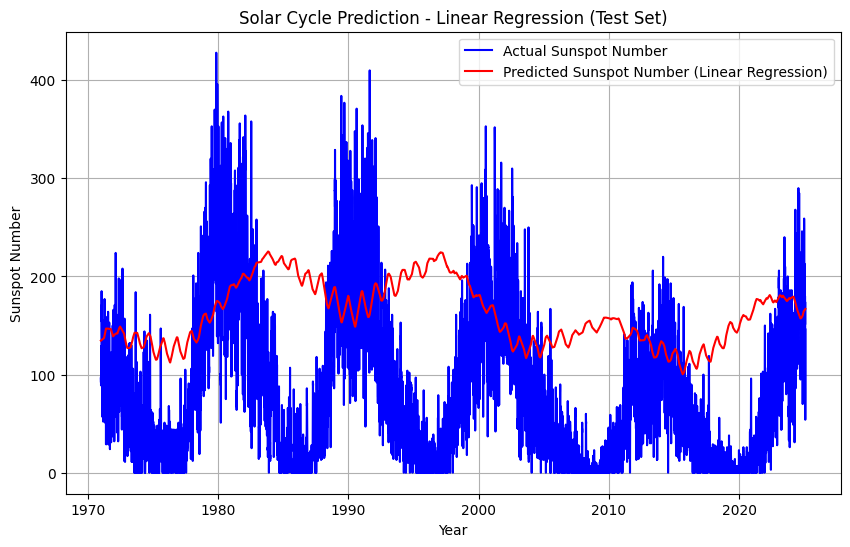

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ... (Assume you have df_with_angles DataFrame with sunspot numbers and angles) ...

# Prepare data for regression
planets = ['earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
planet_pairs = list(combinations(planets, 2)) # Get unique planet pairs
features = [f"{p1}-{p2}" for p1, p2 in planet_pairs]
target = 'Monthly_Sunspot_Number'

start_index = 37254   # 1920 start

X = df_with_angles[start_index:][features] # Handle NaNs (e.g., fill with mean) - consider imputation strategies carefully
y = df_with_angles[start_index:][target]

# Time-based split (e.g., first 50 years for training, rest for testing)
train_years_end = 1970 # Example year to split at
X_train = X[df_with_angles['Year'] <= train_years_end]
X_test = X[df_with_angles['Year'] > train_years_end]
y_train = y[df_with_angles['Year'] <= train_years_end]
y_test = y[df_with_angles['Year'] > train_years_end]


# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse:.2f}")
print(f"R-squared on Test Set: {r2:.2f}")

# (Optional) Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(df_with_angles[df_with_angles['Year'] > train_years_end]['Decimal_Year'], y_test, label='Actual Sunspot Number', color='blue')
plt.plot(df_with_angles[df_with_angles['Year'] > train_years_end]['Decimal_Year'], y_pred, label='Predicted Sunspot Number (Linear Regression)', color='red')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Solar Cycle Prediction - Linear Regression (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
from astropy.coordinates import get_body_barycentric, Galactocentric, ICRS, BarycentricTrueEcliptic

def calculate_planet_galactic_center_angle(planet_name, time):
    """
    Calculates the angle between a planet and the Galactic Center as viewed from the Sun at a given time,
    using the Galactocentric frame.

    Parameters:
    planet_name (str): Name of the planet (e.g., 'jupiter', 'earth').
    time (astropy.time.Time): Time at which to calculate the angle.

    Returns:
    float: Angle between the planet and the Galactic Center in degrees. Returns None if there's an error.
    """
    try:
        planet_pos = get_body_barycentric(planet_name, time)

        # Get direction to Galactic Center by transforming the origin of Galactocentric frame
        # to barycentric frame.  Origin of Galactocentric is at the Galactic Center.
        gc_barycentric = Galactocentric(x=0*u.kpc, y=0*u.kpc, z=0*u.kpc).transform_to(BarycentricTrueEcliptic()) # Use frame class, not string
        gc_pos = gc_barycentric.cartesian.xyz.value # Vector from Sun to Galactic Center (approximately)

        vector_planet = planet_pos.xyz.value # Vector from Sun to Planet (approximately)
        vector_gc = gc_pos

        # Calculate the angle between the two vectors using dot product
        dot_product = np.dot(vector_planet, vector_gc)
        magn_planet = np.linalg.norm(vector_planet)
        magn_gc = np.linalg.norm(vector_gc)

        if magn_planet == 0 or magn_gc == 0:
            return None

        cos_angle = dot_product / (magn_planet * magn_gc)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)

        angle_radians = np.arccos(cos_angle)
        angle_degrees = np.degrees(angle_radians)
        return angle_degrees

    except Exception as e:
        print(f"Error calculating Galactic Center angle for {planet_name}: {e}")
        return None

current_time = Time.now()
start_time = current_time - 10 * u.year
calculate_planet_galactic_center_angle('jupiter', current_time)

162.07715940319682

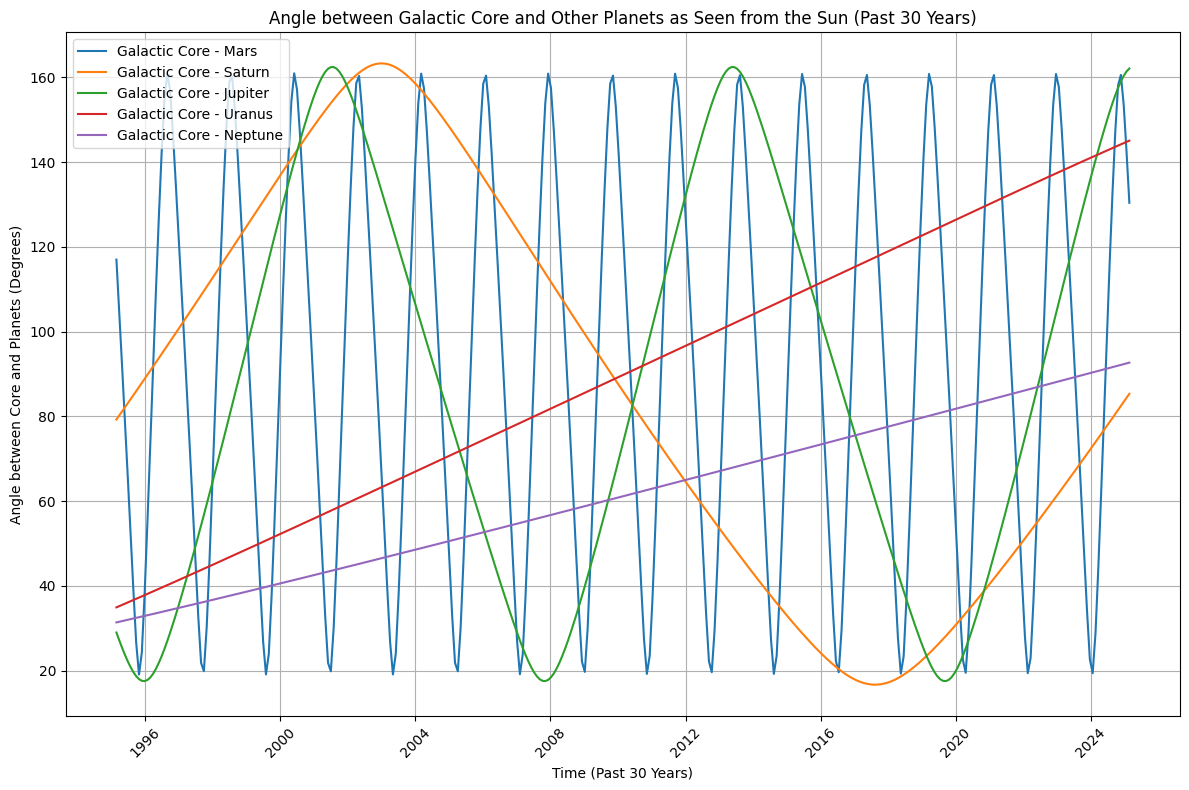

In [58]:
def graph_galactic_core_angles_past_decade():
    """
    Graphs the angle between the galactic core and other planets over the past decade
    over the past 10 years.
    """
    # planets = ['mercury', 'venus', 'earth', 'mars', 'saturn', 'uranus', 'neptune']
    planets = ['mars', 'saturn', 'jupiter', 'uranus', 'neptune']
    current_time = Time.now()
    start_time = current_time - 30 * u.year

    # Create a time range for the past 10 years (e.g., monthly intervals)
    times = Time(np.linspace(start_time.jd, current_time.jd, 360), format='jd') # Roughly monthly for 10 years

    plt.figure(figsize=(12, 8)) # Adjust figure size as needed

    for planet_name in planets:
        angles = []
        for t in times:
            angle = calculate_planet_galactic_center_angle(planet_name, t)
            if angle is not None:
                angles.append(angle)
            else:
                angles.append(np.nan) # Handle potential errors with NaN for plotting

        plt.plot(times.datetime, angles, label=f'Galactic Core - {planet_name.capitalize()}') # Use datetime for better x-axis

    plt.xlabel('Time (Past 30 Years)')
    plt.ylabel('Angle between Core and Planets (Degrees)')
    plt.title('Angle between Galactic Core and Other Planets as Seen from the Sun (Past 30 Years)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

graph_galactic_core_angles_past_decade()

In [299]:
def add_galactic_core_angles_to_dataframe(df):
    """
    Calculates angles between all unique pairs of planets for each time point
    in the input DataFrame and adds them as new columns.

    Parameters:
    df (pandas.DataFrame): DataFrame with a 'Decimal_Year' column representing time.

    Returns:
    pandas.DataFrame: DataFrame with added columns for planet angles.
    """
    planets = ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']

    angle_data = []
    for index, row in df.iterrows(): 
    # for index, row in df[:37254].iterrows():   # start at 1920
    # for index, row in df[75606:].iterrows():  # start at 2025
        if index % 1000 == 0:
            print(index)
        decimal_year = row['Decimal_Year']
        time = Time(decimal_year, format='decimalyear') # Create Time object from decimal year
        angles = {}

        for planet_name in planets:
            gc_angle = calculate_planet_galactic_center_angle(planet_name, time)
            if gc_angle is not None:
                gc_angle_name = f"{planet_name}-galactic_center"
                angles[gc_angle_name] = gc_angle
            else:
                gc_angle_name = f"{planet_name}-galactic_center"
                angles[gc_angle_name] = np.nan

        angles['Decimal_Year'] = decimal_year # Keep Decimal_Year for merging
        angle_data.append(angles)

    angles_df = pd.DataFrame(angle_data)
    merged_df = pd.merge(df, angles_df, on='Decimal_Year', how='left') # Merge based on Decimal_Year
    return merged_df

df_with_galactic_core = add_galactic_core_angles_to_dataframe(df_with_angles.copy())

0


/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/kieran-laptop/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 1 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000


In [301]:
df_with_galactic_core.to_csv("solar_cycles_with_galactic_core_extended.csv", index=False)
df_with_galactic_core[70000:]
# df_with_angles[70000:]

,Year,Month,Day,Decimal_Year,Sunspot_Number,StdDev,Num_Observations,Definitive_Provisional,Sunspot_Number_smoothed_13m,Sunspot_Number_smoothed_30d,...,saturn-neptune,uranus-neptune,mercury-galactic_center,venus-galactic_center,earth-galactic_center,mars-galactic_center,jupiter-galactic_center,saturn-galactic_center,uranus-galactic_center,neptune-galactic_center
70000,2009,8,27,2009.653,0.0,2.0,26.0,1.0,8.420513,0.433333,...,150.838819,29.284233,23.697230,156.366986,68.624248,142.778692,58.508122,91.790984,87.935329,60.136719
70001,2009,8,28,2009.656,0.0,2.0,22.0,1.0,8.405128,0.433333,...,150.808045,29.289365,24.923546,157.411539,69.627222,143.287150,58.598845,91.755208,87.946455,60.142921
70002,2009,8,29,2009.659,0.0,2.0,21.0,1.0,8.492308,0.433333,...,150.777274,29.294497,26.458480,158.368292,70.631362,143.792114,58.689591,91.719435,87.957580,60.149123
70003,2009,8,30,2009.662,0.0,2.0,21.0,1.0,8.584615,0.433333,...,150.746506,29.299629,28.263896,159.224995,71.636631,144.293491,58.780362,91.683664,87.968706,60.155325
70004,2009,8,31,2009.664,0.0,2.0,21.0,1.0,8.664103,0.433333,...,150.725995,29.303050,29.600336,159.734164,72.307420,144.625701,58.840889,91.659819,87.976122,60.159460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81441,2040,12,27,2040.988,NaN,NaN,NaN,NaN,NaN,NaN,...,162.905826,90.832843,42.338152,137.449635,160.162099,19.720978,69.337858,69.778355,137.986269,126.101100
81442,2040,12,28,2040.990,NaN,NaN,NaN,NaN,NaN,NaN,...,162.925277,90.837582,44.277104,138.477558,159.831198,19.837045,69.285488,69.755590,137.978118,126.105265
81443,2040,12,29,2040.993,NaN,NaN,NaN,NaN,NaN,NaN,...,162.954452,90.844690,47.288163,140.008568,159.295877,20.026127,69.206936,69.721444,137.965891,126.111512
81444,2040,12,30,2040.996,NaN,NaN,NaN,NaN,NaN,NaN,...,162.983625,90.851799,50.420019,141.524987,158.716926,20.232824,69.128389,69.687301,137.953662,126.117760


In [302]:
def add_trig_functions(df, angle_column_names):
    """
    Transforms columns in a DataFrame that represent angles (identified by names ending in "Angle")
    to the absolute value of the sine of the angle (in radians).

    Parameters:
    df (pandas.DataFrame): DataFrame containing angle columns.

    Returns:
    pandas.DataFrame: DataFrame with angle columns transformed to abs(sin(angle)).
                      Returns a copy of the DataFrame to avoid modifying the original.
    """
    df_transformed = df.copy() # Create a copy to avoid modifying the original DataFrame

    for col_name in angle_column_names:
        if col_name in df_transformed.columns: # Check if column exists in DataFrame
            # Convert angles from degrees to radians

            df_transformed[f'{col_name}-sin'] = np.sin(np.deg2rad(df_transformed[col_name]))
            df_transformed[f'{col_name}-cos'] = np.cos(np.deg2rad(df_transformed[col_name]))

    return df_transformed

planets = ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
planet_pairs = list(combinations(planets, 2)) # Get unique planet pairs
angle_columns = [f"{p1}-{p2}" for p1, p2 in planet_pairs] + [f"{p}-galactic_center" for p in planets]
df_with_trig = add_trig_functions(df_with_galactic_core, angle_columns)
# df_with_sin[70000:]
df_with_trig.to_csv("solar_cycles_with_trig.csv", index=False)

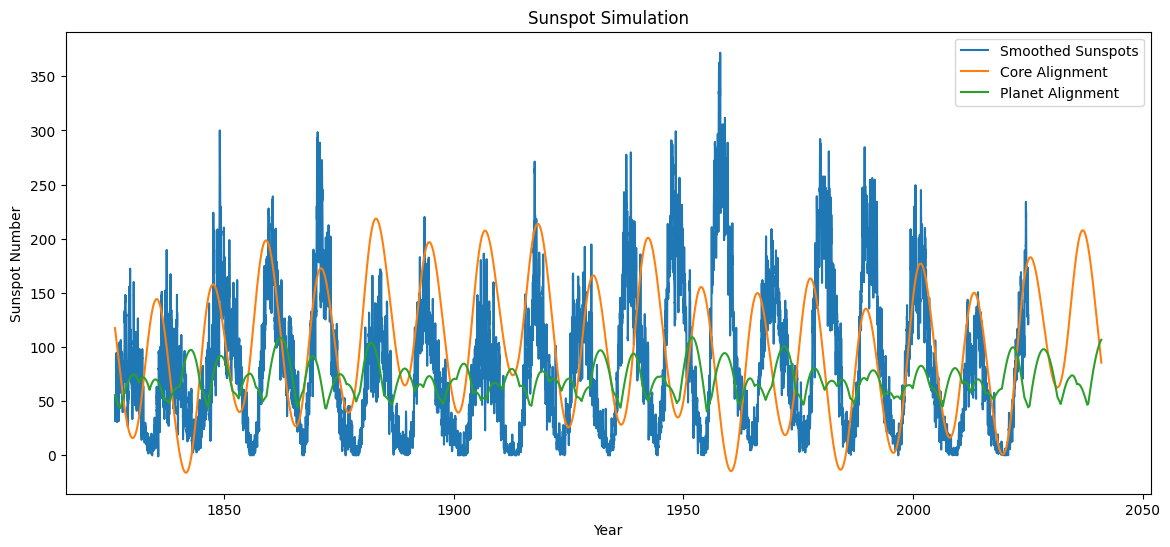

In [372]:
def simulate_sunspots(df, planets, galactic_core_influence = 5):
    """
    Simulates sunspot numbers based on planetary alignments and Galactic Core influence
    using the methods described in the Mathis papers.

    Args:
        df (pd.DataFrame): DataFrame with planetary angles (absolute value of sine).
        planets (list): List of planet names (used in column naming).
        galactic_core_influence (float): scaling factor for the GC.

    Returns:
        pd.DataFrame: DataFrame with added 'Simulated_Sunspots' column.
    """
    df['core_alignment'] = 0.0
    df['planet_alignment'] = 0.0
    df['Simulated_Sunspots'] = 0.0

    # Constants and Weights (These are tuning parameters - adjust for best results)
    planet_weights = {  # Example weights, adjust based on Mathis' discussion
        'mercury': 0.01,
        'venus': 0.02,
        'earth': 0.03,
        'mars': 0.04,
        'jupiter': -1,
        'saturn': -0.29,
        'uranus': -0.16,
        'neptune': -0.38,
    }

    # Galactic Core Influence
    # for planet in planets:
    #     df['Simulated_Sunspots'] += df[f"{planet}-galactic_center"] * planet_weights[planet]

    df['core_alignment'] += (np.cos(np.deg2rad(df["jupiter-galactic_center"])) * jupiter_weight +
                                np.cos(np.deg2rad(df["saturn-galactic_center"])) * saturn_weight +
                                np.sin(np.deg2rad(df["uranus-galactic_center"])) * uranus_weight +
                                np.cos(np.deg2rad(df["neptune-galactic_center"])) * neptune_weight) * 79.89 + 112.82

    for p1, p2 in combinations(planets, 2):
        if p1 == 'uranus' or p2 == 'uranus':
            df['planet_alignment'] += np.abs(np.sin(np.deg2rad(df[f"{p1}-{p2}"]))) * -1 * (planet_weights[p1] + planet_weights[p2])
        else:
            df['planet_alignment'] += np.abs(np.cos(np.deg2rad(df[f"{p1}-{p2}"]))) * -1 * (planet_weights[p1] + planet_weights[p2])

    df['Simulated_Sunspots'] = df['core_alignment'] + df['planet_alignment'] * 20
    
    # df['Simulated_Sunspots'] += (np.cos(np.deg2rad(df["jupiter-galactic_center"])) * jupiter_weight +
    #                             np.cos(np.deg2rad(df["saturn-galactic_center"])) * saturn_weight +
    #                             np.sin(np.deg2rad(df["uranus-galactic_center"])) * uranus_weight +
    #                             np.cos(np.deg2rad(df["neptune-galactic_center"])) * neptune_weight) * 79.89 + 112.82

    


    # ji = np.array([np.cos(np.deg2rad(x - galactic_core)) * jupiter_weight for x in jupiter_angles])
    # si = np.array([np.cos(np.deg2rad(x - galactic_core)) * saturn_weight for x in saturn_angles])
    # ui = np.array([np.sin(np.deg2rad(x - galactic_core)) * uranus_weight for x in uranus_angles])
    # ni = np.array([np.cos(np.deg2rad(x - galactic_core)) * neptune_weight for x in neptune_angles])
    # print(ji[0], si[0], ui[0], ni[0])
    # ti = ji + si + ui + ni
    # ti = ti * 79.89 + 112.82

    # Planet-Planet Alignment Influence
    # for p1, p2 in combinations(planets, 2):
    #     df['Simulated_Sunspots'] += df[f"{p1}-{p2}"] * (planet_weights[p1] + planet_weights[p2]) * 0.1 # Adjust scaling as needed

    # # Uranus Correction
    # df['Simulated_Sunspots'] += df[f"uranus-galactic_center"] * planet_weights['uranus'] * 0.2 # Uranus acts orthogonal

    # Normalizing the Simulated Sunspots:
    # Adjust as needed to align with the scale of your actual sunspot numbers
    # df['Simulated_Sunspots'] = df['Simulated_Sunspots'] * 200  # Example scaling
    df['Simulated_Sunspots'] = df['Simulated_Sunspots'].clip(lower=0) #Ensures no negative values

    return df

planets = ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
df_simulation = simulate_sunspots(df_with_trig, ['jupiter', 'saturn', 'uranus', 'neptune'])
planet_weights = {  # Example weights, adjust based on Mathis' discussion
    'mercury': 0.01,
    'venus': 0.02,
    'earth': 0.03,
    'mars': 0.04,
    'jupiter': -1,
    'saturn': -0.29,
    'uranus': -0.16,
    'neptune': -0.38,
}

start_index = 37254
start_index = 11688     # 1850 start
start_index = 3000
# start_index = 70000

#Basic Plotting Example
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
# plt.plot(df_simulation['Decimal_Year'][start_index:], df_simulation['Monthly_Sunspot_Number'][start_index:], label='Observed Sunspots')
plt.plot(df_simulation['Decimal_Year'][start_index:], df_simulation['Sunspot_Number_smoothed_30d'][start_index:], label='Smoothed Sunspots')
plt.plot(df_simulation['Decimal_Year'][start_index:], df_simulation['core_alignment'][start_index:], label='Core Alignment')
plt.plot(df_simulation['Decimal_Year'][start_index:], df_simulation['planet_alignment'][start_index:] * 20, label='Planet Alignment')
# plt.plot(df_simulation['Decimal_Year'][start_index:], df_simulation['Simulated_Sunspots'][start_index:], label='Simulated Sunspots')
# for p1, p2 in combinations(['jupiter', 'saturn', 'uranus', 'neptune'], 2):
#     if p1 == 'uranus' or p2 == 'uranus':
#         plt.plot(df_simulation['Decimal_Year'][start_index:], np.abs(np.sin(np.deg2rad(df_with_galactic_core[f"{p1}-{p2}"][start_index:]))) * -1 * (planet_weights[p1] + planet_weights[p2]) / 1.38, label=f'{p1} {p2}')
#     else:
#         plt.plot(df_simulation['Decimal_Year'][start_index:], np.abs(np.cos(np.deg2rad(df_with_galactic_core[f"{p1}-{p2}"][start_index:]))) * -1 * (planet_weights[p1] + planet_weights[p2]) / 1.38, label=f'{p1} {p2}')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Simulation')
plt.legend()
plt.gcf().patch.set_facecolor('none') # Or set_alpha(0)
# plt.grid(True)
plt.savefig('sunspot_simulation.png')
plt.show()

[1823.385, 1833.826, 1843.599, 1856.012, 1867.155, 1878.747, 1888.925, 1901.434, 1913.544, 1923.618, 1933.73, 1944.179, 1954.322, 1964.827, 1976.422, 1986.725, 1996.357, 2008.791, 2019.914]
10.918277777777778
9.632000000000062 12.509000000000015
2.8769999999999527
[10.441000000000031, 9.77299999999991, 12.413000000000011, 11.143000000000029, 11.592000000000098, 10.177999999999884, 12.509000000000015, 12.110000000000127, 10.073999999999842, 10.11200000000008, 10.44900000000007, 10.142999999999802, 10.50500000000011, 11.595000000000027, 10.302999999999884, 9.632000000000062, 12.433999999999969, 11.123000000000047]


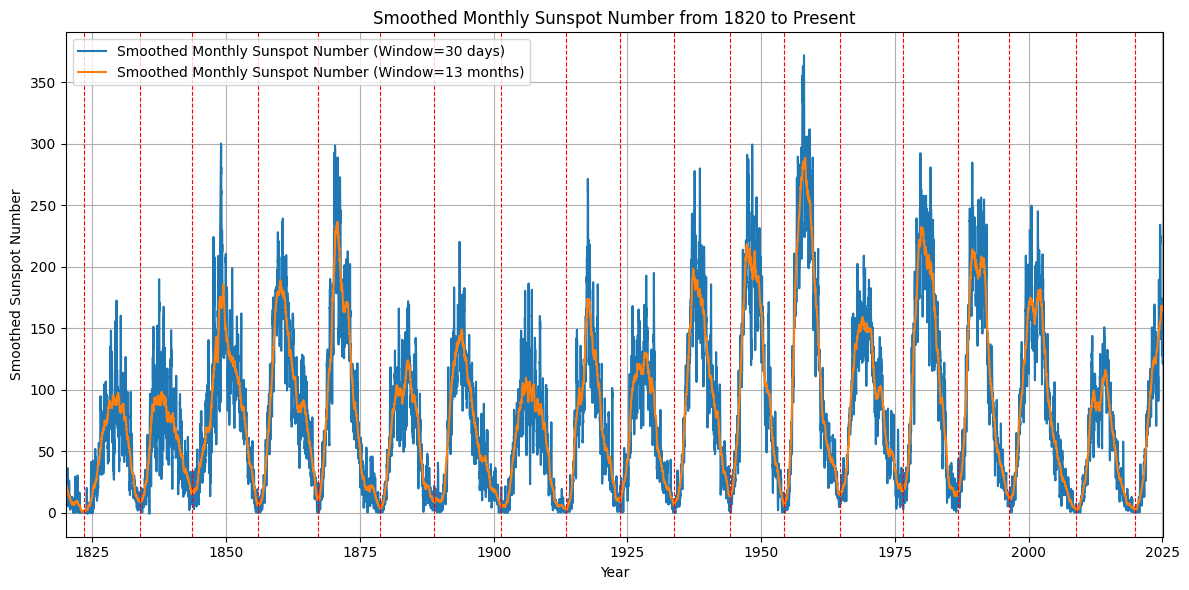

In [399]:
# Calculate cycle lengths

find_low = True
end_dates = []
low_val = 25
cur_date = 1820.001
for index, row in df_with_trig.iterrows():
    if row['Sunspot_Number_smoothed_13m'] < low_val:
        low_val = row['Sunspot_Number_smoothed_13m']
        cur_date = row['Decimal_Year']
    elif row['Sunspot_Number_smoothed_13m'] > 50 and low_val < 25:
        end_dates.append(cur_date)
        low_val = 25

print(end_dates)
solar_cycle_lengths = [end_dates[i + 1] - end_dates[i] for i in range(len(end_dates) - 1)]
mean_solar_cycle = np.mean(solar_cycle_lengths)
print(np.mean(solar_cycle_lengths))
range_solar_cycle = max(solar_cycle_lengths) - min(solar_cycle_lengths)
print(min(solar_cycle_lengths), max(solar_cycle_lengths))
print(range_solar_cycle)
print(solar_cycle_lengths)


start_year_plot = 1820
plot_data = sunspot_data[sunspot_data['Year'] >= start_year_plot]

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Decimal_Year'], plot_data['Sunspot_Number_smoothed_30d'], label=f'Smoothed Monthly Sunspot Number (Window={30} days)')
plt.plot(plot_data['Decimal_Year'], plot_data['Sunspot_Number_smoothed_13m'], label=f'Smoothed Monthly Sunspot Number (Window={13} months)')
for end_date in end_dates:
    plt.axvline(x=end_date, color='r', linestyle='--', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel('Smoothed Sunspot Number')
plt.title(f'Smoothed Monthly Sunspot Number from {start_year_plot} to Present')
plt.xlim(start_year_plot, plot_data['Decimal_Year'].max()) # Set x-axis limits
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('solar cycle lengths.png')
plt.show()

[1818.001, 1830.073, 1841.667, 1853.377, 1865.599, 1877.084, 1889.352, 1900.985, 1912.862, 1924.985, 1936.441, 1948.777, 1960.367, 1972.146, 1984.212, 1995.727, 2008.007, 2019.527, 2031.415]
11.856333333333332
0.8799999999998818
[12.072000000000116, 11.593999999999824, 11.710000000000036, 12.22199999999998, 11.485000000000127, 12.268000000000029, 11.63299999999981, 11.87700000000018, 12.12299999999982, 11.456000000000131, 12.336000000000013, 11.589999999999918, 11.778999999999996, 12.066000000000031, 11.5150000000001, 12.279999999999973, 11.519999999999982, 11.88799999999992]


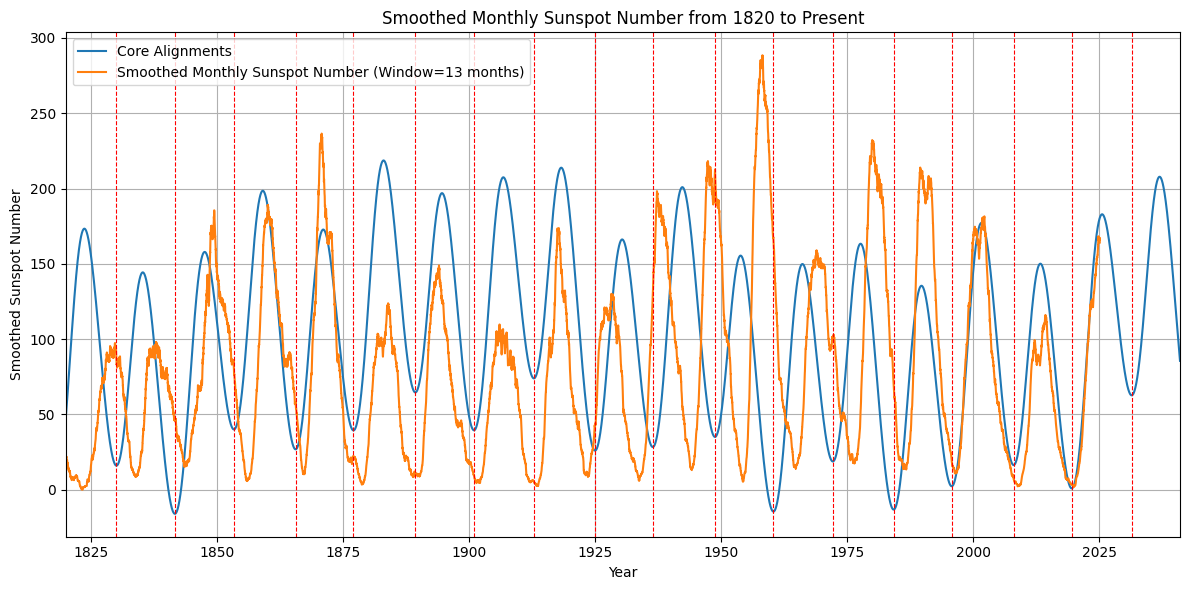

In [398]:
# Calculate cycle lengths

find_low = True
end_dates = []
low_val = 80
cur_date = 1820.001
for index, row in df_simulation.iterrows():
    if row['core_alignment'] < low_val:
        low_val = row['core_alignment']
        cur_date = row['Decimal_Year']
    elif row['core_alignment'] > 100 and low_val < 80:
        end_dates.append(cur_date)
        low_val = 80

print(end_dates)
core_alignment_cycle_lengths = [end_dates[i + 1] - end_dates[i] for i in range(len(end_dates) - 1)]
mean_core_alignment = np.mean(core_alignment_cycle_lengths)
print(mean_core_alignment)
range_core_alignment = max(core_alignment_cycle_lengths) - min(core_alignment_cycle_lengths)
print(range_core_alignment)
print(core_alignment_cycle_lengths)


start_year_plot = 1820
plot_data = df_simulation[df_simulation['Year'] >= start_year_plot]

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Decimal_Year'], plot_data['core_alignment'], label=f'Core Alignments')
plt.plot(plot_data['Decimal_Year'], plot_data['Sunspot_Number_smoothed_13m'], label=f'Smoothed Monthly Sunspot Number (Window={13} months)')
for end_date in end_dates:
    plt.axvline(x=end_date, color='r', linestyle='--', linewidth=0.8)
plt.xlabel('Year')
plt.ylabel('Smoothed Sunspot Number')
plt.title(f'Smoothed Monthly Sunspot Number from {start_year_plot} to Present')
plt.xlim(start_year_plot, plot_data['Decimal_Year'].max()) # Set x-axis limits
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('core alignment lengths.png')
plt.show()

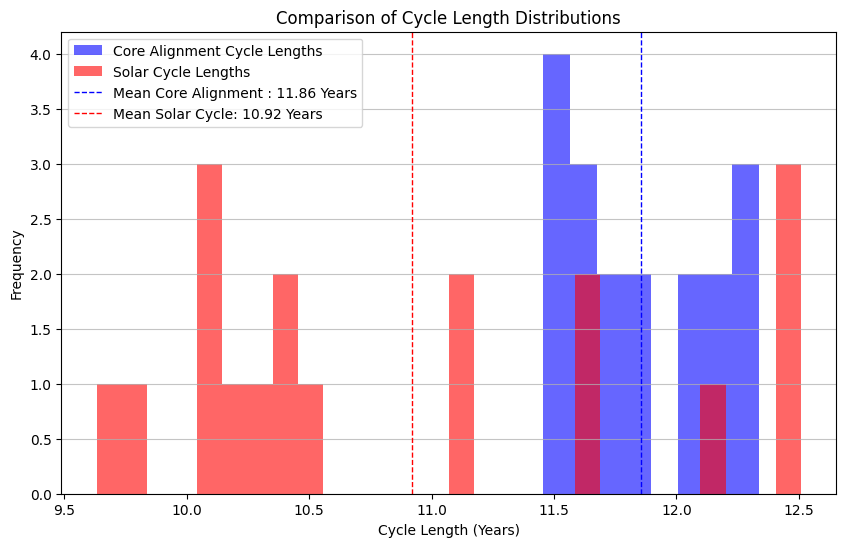

In [397]:
plt.figure(figsize=(10, 6))

plt.hist(core_alignment_cycle_lengths, bins=int(10 * range_core_alignment), alpha=0.6, label='Core Alignment Cycle Lengths', color='blue')
plt.hist(solar_cycle_lengths, bins=int(10 * range_solar_cycle), alpha=0.6, label='Solar Cycle Lengths', color='red')
plt.axvline(mean_core_alignment, color='blue', linestyle='dashed', linewidth=1, label=f'Mean Core Alignment : {mean_core_alignment:.2f} Years')
plt.axvline(mean_solar_cycle, color='red', linestyle='dashed', linewidth=1, label=f'Mean Solar Cycle: {mean_solar_cycle:.2f} Years')

plt.xlabel('Cycle Length (Years)')
plt.ylabel('Frequency')
plt.title('Comparison of Cycle Length Distributions')
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.75)
plt.savefig('cycle length histogram.png')

plt.show()

11322
11322
11322


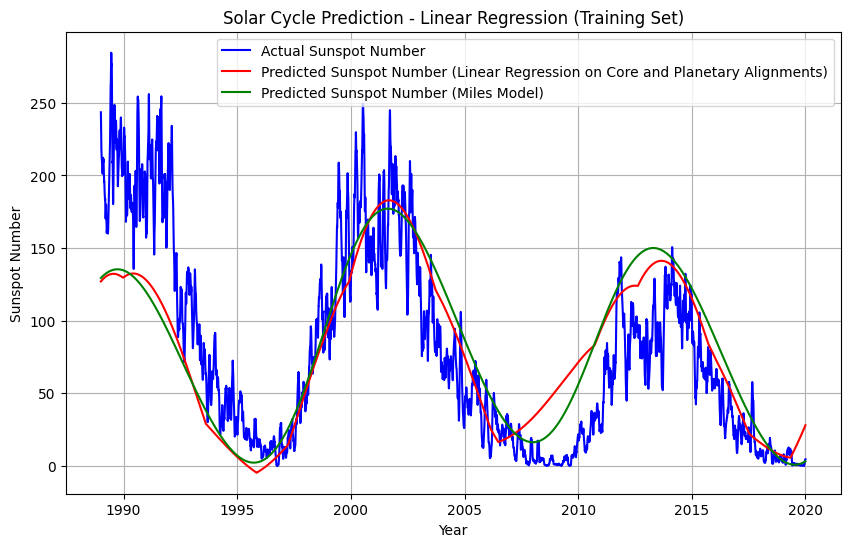

In [419]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ... (Assume you have df_data DataFrame with sunspot numbers and angles) ...

# Prepare data for regression
# planets = ['earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
planets = ['jupiter', 'saturn', 'uranus', 'neptune']
# planet_pairs = list(combinations(planets, 2)) # Get unique planet pairs
# features = [f"{p1}-{p2}" for p1, p2 in planet_pairs] + [f"{p}-galactic_center" for p in planets]
# features = [f"{p1}-{p2}-cos" for p1, p2 in planet_pairs] + [f"{p}-galactic_center-cos" for p in planets] + \
#            [f"{p1}-{p2}-sin" for p1, p2 in planet_pairs] + [f"{p}-galactic_center-sin" for p in planets]
features = ['planet_alignment']
features = ['core_alignment']
features = ['core_alignment', 'planet_alignment']
target = 'Sunspot_Number_smoothed_30d'

# start_index = 37254   # 1920 start
start_index = 62457  # 1989
# end_index = 75513     # end of confirmed data
end_index = 74144 # 2020

df_data = df_simulation[start_index:end_index]

X = df_data[features] # Handle NaNs (e.g., fill with mean) - consider imputation strategies carefully
y = df_data[target]

# Time-based split (e.g., first 50 years for training, rest for testing)
train_years_end = 2019 # Example year to split at
X_train = X[df_data['Year'] <= train_years_end]
X_test = X[df_data['Year'] > train_years_end]
y_train = y[df_data['Year'] <= train_years_end]
y_test = y[df_data['Year'] > train_years_end]


# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = model.predict(X_train)  # Comment out when not testing training accuracy

print(len(y_pred))
print(len(y_train))
print(len(df_data[df_data['Year'] <= train_years_end]['Decimal_Year']))

# Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error on Test Set: {mse:.2f}")
# print(f"R-squared on Test Set: {r2:.2f}")

# (Optional) Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
# plt.plot(df_data[df_data['Year'] > train_years_end]['Decimal_Year'], y_test, label='Actual Sunspot Number', color='blue')
# plt.plot(df_data[df_data['Year'] > train_years_end]['Decimal_Year'], y_pred, label='Predicted Sunspot Number (Linear Regression)', color='red')
# plt.plot(df_data[df_data['Year'] > train_years_end]['Decimal_Year'], X_test * 79.89 + 112.82, label='Simulated Sunspot Number', color='green')


plt.plot(df_data[df_data['Year'] <= train_years_end]['Decimal_Year'], y_train, label='Actual Sunspot Number', color='blue')
plt.plot(df_data[df_data['Year'] <= train_years_end]['Decimal_Year'], y_pred, label='Predicted Sunspot Number (Linear Regression on Core and Planetary Alignments)', color='red')
plt.plot(df_data[df_data['Year'] <= train_years_end]['Decimal_Year'], df_data[df_data['Year'] <= train_years_end]['core_alignment'], label='Predicted Sunspot Number (Miles Model)', color='green')


plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Solar Cycle Prediction - Linear Regression (Training Set)')
plt.legend()
plt.grid(True)
plt.savefig('linear regression inside.png')
plt.show()

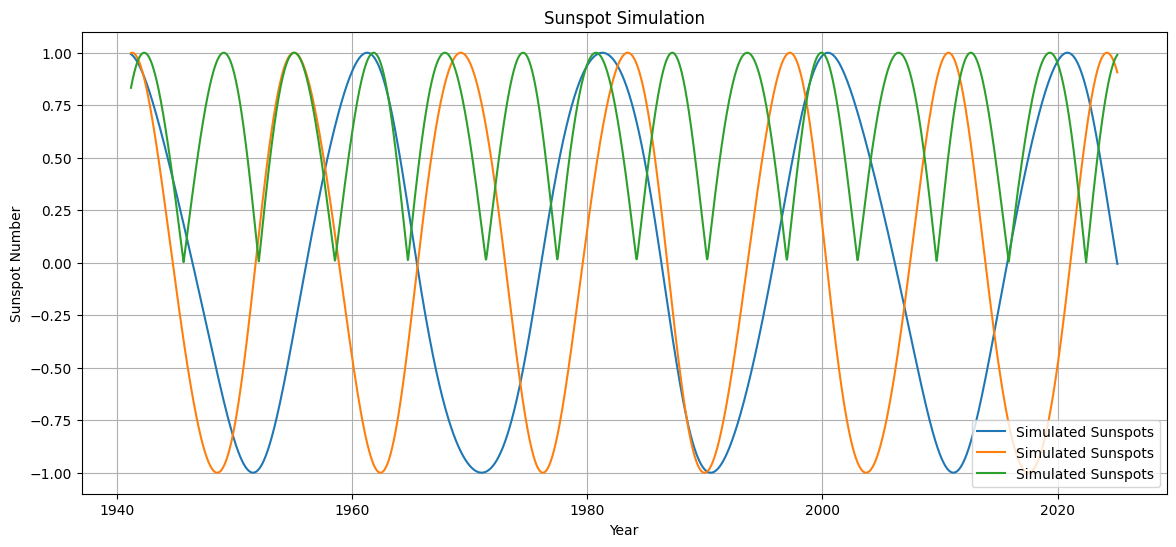

In [178]:
plt.figure(figsize=(14,6))
plt.plot(df_simulation['Decimal_Year'][45000:], np.cos(np.deg2rad(df_simulation['jupiter-saturn'][45000:])), label='Simulated Sunspots')
plt.plot(df_simulation['Decimal_Year'][45000:], np.cos(np.deg2rad(df_simulation['jupiter-uranus'][45000:])), label='Simulated Sunspots')
plt.plot(df_simulation['Decimal_Year'][45000:], np.sin(np.deg2rad(df_simulation['jupiter-neptune'][45000:])), label='Simulated Sunspots')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Simulation')
plt.legend()
plt.grid(True)
plt.show()

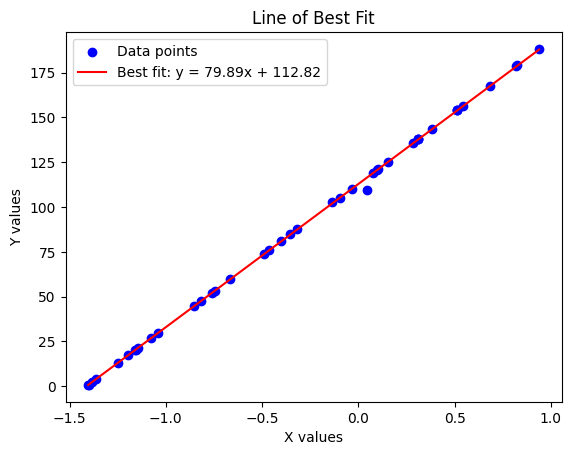

(79.89285870314029, 112.8219868510521)

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Data points
x_values = [-0.462, -0.034, 0.283, 0.310, 0.077, -0.317, -0.760, -1.145, -1.384, -1.403, -1.157, -0.746, 0.046, 
            0.511, 0.825, 0.821, 0.545, 0.100, -0.402, -0.852, -1.160, -1.250, -1.076, -0.664, -0.137, 0.310, 
            0.513, 0.384, 0.098, -0.353, -0.819, -1.197, -1.401, -1.361, -1.042, -0.491, 0.153, 0.513, 0.939, 
            0.684, 0.310, -0.097]

y_values = [76.0, 110.3, 135.7, 137.8, 119.1, 87.6, 52.2, 21.4, 2.3, 0.8, 20.4, 53.3, 109.3, 153.9, 179.0, 178.7, 
            156.6, 121.0, 80.9, 44.8, 20.2, 13.0, 26.9, 59.9, 102.8, 137.8, 154.1, 143.7, 120.9, 84.8, 47.5, 17.3, 
            0.9, 4.2, 29.7, 73.7, 125.2, 154.1, 188.2, 167.7, 137.8, 105.3]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Generate best fit line
x_fit = np.linspace(min(x_values), max(x_values), 100)
y_fit = slope * x_fit + intercept

# Plot data and best fit line
plt.scatter(x_values, y_values, label="Data points", color="blue")
plt.plot(x_fit, y_fit, label=f"Best fit: y = {slope:.2f}x + {intercept:.2f}", color="red")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.title("Line of Best Fit")
plt.show()

# Output equation
slope, intercept


In [158]:
jupiter_angles = [
    3.45, 31.48, 64.50, 96.18, 126.33, 155.12, 183.10, 210.72, 238.67, 267.57, 
    297.93, 324.77, 2.82, 36.25, 69.15, 100.62, 130.52, 159.10, 186.97, 214.57, 
    242.63, 271.73, 302.38, 334.48, 7.68, 41.10, 73.83, 109.95, 134.72, 163.15, 
    190.93, 218.57, 246.75, 276.05, 306.93, 339.23, 12.50, 45.83, 78.35, 109.33, 
    138.80, 167.12, 194.88
]
saturn_angles = [254.83, 264.08, 275.12, 286.12, 297.18, 308.35, 319.70, 331.20, 342.93, 354.92, 7.22, 19.78, 32.62, 45.70, 59.05, 72.53, 86.13, 99.77, 113.40, 126.87, 140.17, 153.23, 166.07, 178.58, 190.80, 202.77, 214.50, 227.82, 237.28, 248.43, 259.52, 270.52, 281.50, 292.52, 303.93, 314.87, 326.27, 337.88, 349.78, 1.92, 14.33, 27.03, 40.05]
uranus_angles = [263.47, 267.05, 271.32, 275.53, 279.72, 283.88, 288.03, 292.15, 296.23, 300.32, 304.37, 308.55, 312.42, 316.40, 320.40, 324.35, 328.30, 332.23, 336.17, 340.08, 344.00, 347.92, 351.85, 355.77, 359.68, 3.62, 7.55, 12.13, 15.43, 19.38, 23.35, 27.32, 31.30, 35.32, 39.37, 43.42, 47.50, 51.60, 55.75, 59.90, 64.08, 68.28, 72.53]
neptune_angles = [275.90, 277.73, 279.90, 282.08, 284.25, 286.43, 288.62, 290.80, 292.98, 295.17, 297.35, 299.55, 301.73, 303.92, 306.12, 308.30, 310.48, 312.68, 314.88, 317.07, 319.27, 321.47, 323.68, 325.90, 328.10, 330.32, 332.52, 335.08, 336.93, 339.13, 341.35, 343.57, 345.77, 347.98, 350.22, 352.45, 354.67, 356.90, 359.13, 1.37, 3.58, 5.82, 8.03]
dates = [x + 0.001 for x in range(1987, 2030)]
galactic_core = 262
jupiter_weight = -1
saturn_weight = -0.29
uranus_weight = -0.16
neptune_weight = -0.38
ji = np.array([np.cos(np.deg2rad(x - galactic_core)) * jupiter_weight for x in jupiter_angles])
si = np.array([np.cos(np.deg2rad(x - galactic_core)) * saturn_weight for x in saturn_angles])
ui = np.array([np.sin(np.deg2rad(x - galactic_core)) * uranus_weight for x in uranus_angles])
ni = np.array([np.cos(np.deg2rad(x - galactic_core)) * neptune_weight for x in neptune_angles])
print(ji[0], si[0], ui[0], ni[0])
ti = ji + si + ui + ni
ti = ti * 79.89 + 112.82
# print(ti)
print(ji)

0.19851271298619508 -0.28773225499623195 -0.004104564062741685 -0.36887226299971254
[ 0.19851271  0.63580883  0.95371695  0.96953092  0.71532695  0.29036818
 -0.19252197 -0.62551504 -0.91823915 -0.99527836 -0.80973451 -0.45756356
  0.18772419  0.69779046  0.97495565  0.94765701  0.66235857  0.22325012
 -0.25831325 -0.67649046 -0.94339645 -0.98561511 -0.7617645  -0.30103869
  0.27026439  0.75585347  0.98985078  0.88335695  0.60571069  0.15384817
 -0.32441274 -0.72621481 -0.96478732 -0.97008424 -0.70797015 -0.22103788
  0.35020738  0.80726944  0.99797155  0.88837696  0.54756322  0.08506913
 -0.38880237]


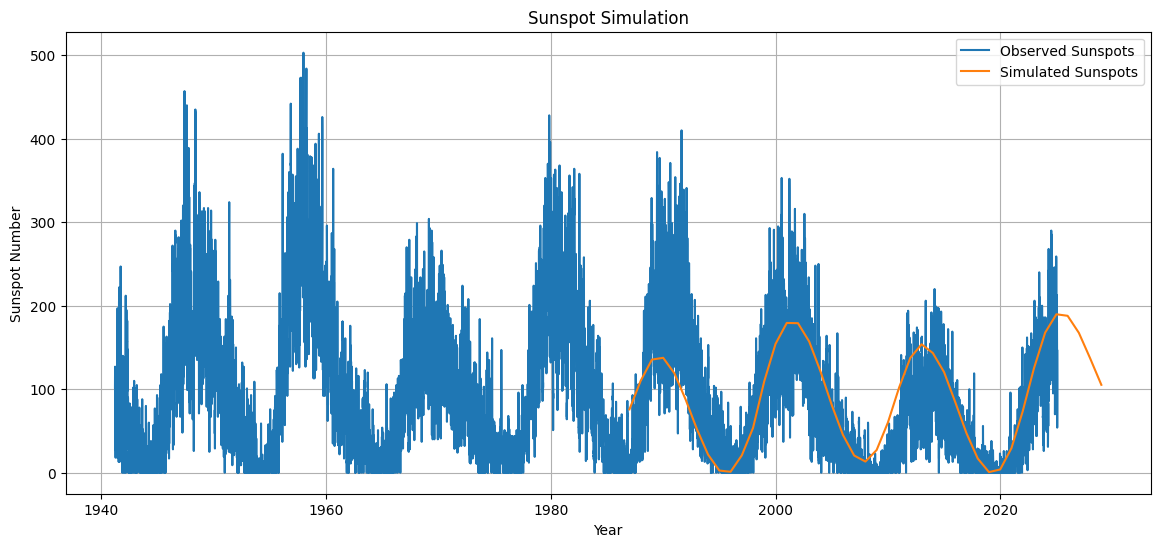

In [155]:
plt.figure(figsize=(14,6))
plt.plot(df_simulation['Decimal_Year'][45000:], df_simulation['Monthly_Sunspot_Number'][45000:], label='Observed Sunspots')
plt.plot(dates, ti, label='Simulated Sunspots')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Simulation')
plt.legend()
plt.grid(True)
plt.show()

[ 0.19851271  0.63580883  0.95371695  0.96953092  0.71532695  0.29036818
 -0.19252197 -0.62551504 -0.91823915 -0.99527836 -0.80973451 -0.45756356
  0.18772419  0.69779046  0.97495565  0.94765701  0.66235857  0.22325012
 -0.25831325 -0.67649046 -0.94339645 -0.98561511 -0.7617645  -0.30103869
  0.27026439  0.75585347  0.98985078  0.88335695  0.60571069  0.15384817
 -0.32441274 -0.72621481 -0.96478732 -0.97008424 -0.70797015 -0.22103788
  0.35020738  0.80726944  0.99797155  0.88837696  0.54756322  0.08506913
 -0.38880237] [0.034169895629654806, 0.5528262977236883, 0.8866426138260312, 0.9387646496998221, 0.728475128048336, 0.3426866775547284, -0.11426700393842555, -0.5396490872431703, -0.8450663023178505, -0.9531952376616466, -0.81124784115043, -0.4248380289926957, 0.10932508797309887, 0.6129310481183055, 0.9112694013887459, 0.9237008781502022, 0.683015380665419, 0.2816269227156661, -0.17631257926200725, -0.5900307488169695, -0.8728355386837021, -0.9492690036422307, -0.771264318292624, -0.

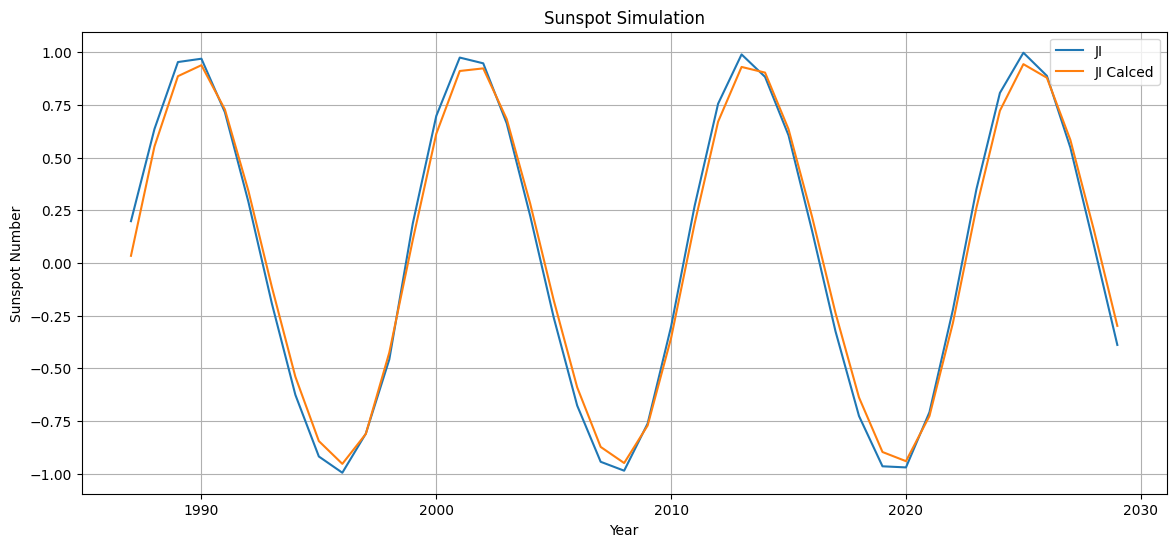

In [167]:
ji_calced = [-1 * np.cos(np.deg2rad(calculate_planet_galactic_center_angle('jupiter', Time(date, format='decimalyear')))) for date in dates]
print(ji, ji_calced)
plt.figure(figsize=(14,6))
plt.plot(dates, ji, label='JI')
plt.plot(dates, ji_calced, label='JI Calced')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Simulation')
plt.legend()
plt.grid(True)
plt.show()

[-0.28773225 -0.28980893 -0.28243007 -0.26468056 -0.23703036 -0.20017286
 -0.15496218 -0.10298102 -0.0457159   0.01477305  0.07613254  0.13516257
  0.18880137  0.2337192   0.26704519  0.28604785  0.28924693  0.2761639
  0.24752973  0.20552571  0.15294621  0.0933133   0.02996087 -0.03323121
 -0.09345705 -0.14836198 -0.19592116 -0.23991025 -0.26342506 -0.28190436
 -0.28972838 -0.28679962 -0.27336603 -0.24982106 -0.21574891 -0.1750514
 -0.12589794 -0.07074653 -0.01123362  0.04995916  0.11018276  0.16646153
  0.21568126] [-0.2708059100006934, -0.2775990355573637, -0.27412486836368816, -0.26055077636386476, -0.237239640278334, -0.20477045816061537, -0.16385223027532964, -0.11584160876932262, -0.0621262399846617, -0.004599703526101741, 0.05457620356889849, 0.11234734504934586, 0.16584278844930622, 0.21190153542271353, 0.24757277344552697, 0.2700760209462636, 0.2777327807759619, 0.2698179120683077, 0.24673265327514834, 0.21025543052093393, 0.16292980399766085, 0.10792879242163926, 0.048469173

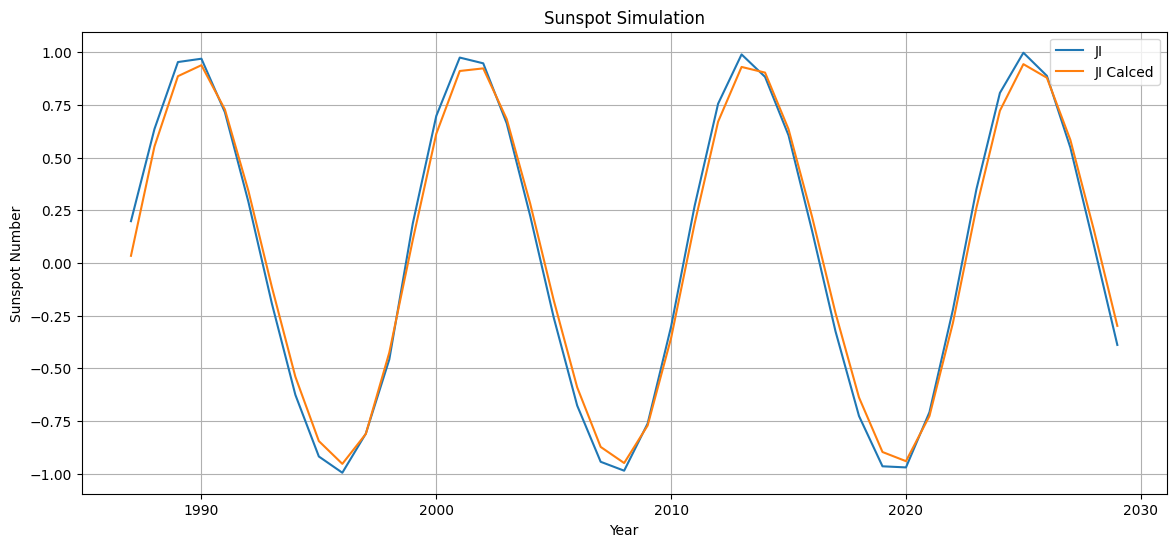

In [168]:
si_calced = [saturn_weight * np.cos(np.deg2rad(calculate_planet_galactic_center_angle('saturn', Time(date, format='decimalyear')))) for date in dates]
print(si, si_calced)
plt.figure(figsize=(14,6))
plt.plot(dates, ji, label='JI')
plt.plot(dates, ji_calced, label='JI Calced')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Simulation')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error on Test Set: 0.5127
R-squared on Test Set: -0.1580


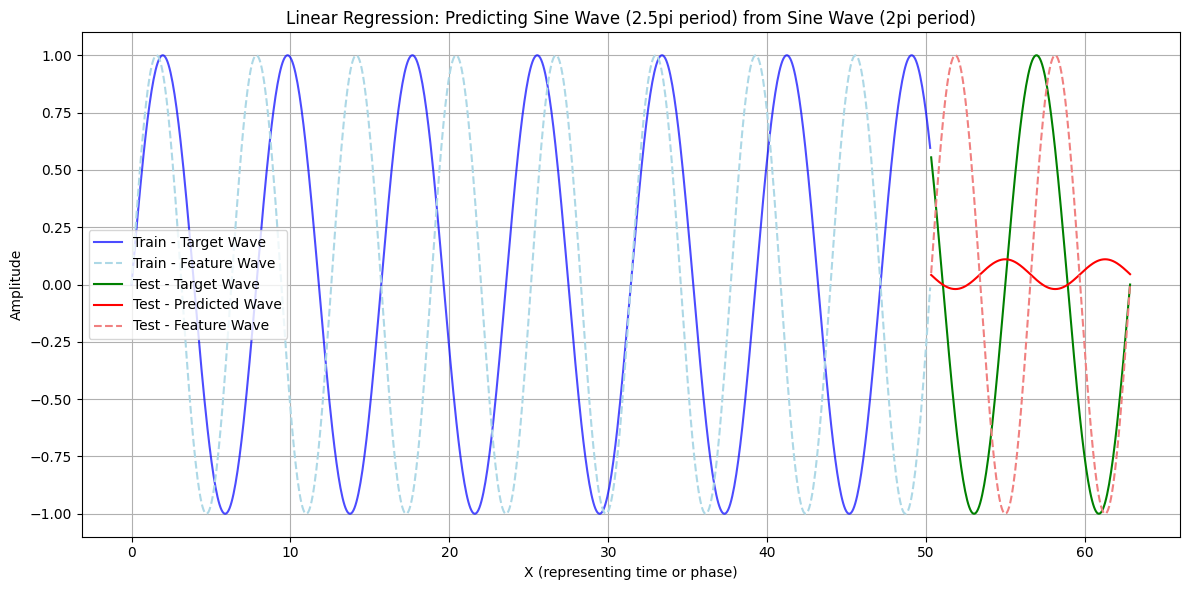

In [250]:
# 1. Generate the data
period_feature = 2 * np.pi
period_target = 2.5 * np.pi
num_wavelengths = 10
points_per_wavelength = 100  # Sample points for smoothness
total_points = num_wavelengths * points_per_wavelength

# Generate x values spanning 10 wavelengths of the feature wave
x = np.linspace(0, num_wavelengths * period_feature, total_points)

# Generate feature sine wave (period 2pi)
feature_wave = np.sin(2 * np.pi * x / period_feature)

# Generate target sine wave (period 2.5pi)
target_wave = np.sin(2 * np.pi * x / period_target)

# 2. Prepare data for regression
X = feature_wave.reshape(-1, 1)  # Feature needs to be 2D array (samples, features)
y = target_wave               # Target is 1D array

# 3. Split into train and test sets (80% train, 20% test based on wavelengths)
train_size = int(0.8 * total_points)  # 80% of total points
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 4. Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"R-squared on Test Set: {r2:.4f}")

# 7. Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(x[:train_size], y_train, label='Train - Target Wave', color='blue', alpha=0.7)
plt.plot(x[:train_size], X_train, label='Train - Feature Wave', color='lightblue', linestyle='--')
plt.plot(x[train_size:], y_test, label='Test - Target Wave', color='green')
plt.plot(x[train_size:], y_pred, label='Test - Predicted Wave', color='red', linestyle='-')
plt.plot(x[train_size:], X_test, label='Test - Feature Wave', color='lightcoral', linestyle='--')


plt.xlabel('X (representing time or phase)')
plt.ylabel('Amplitude')
plt.title('Linear Regression: Predicting Sine Wave (2.5pi period) from Sine Wave (2pi period)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mean Squared Error on Test Set: 0.5029
R-squared on Test Set: -0.1358


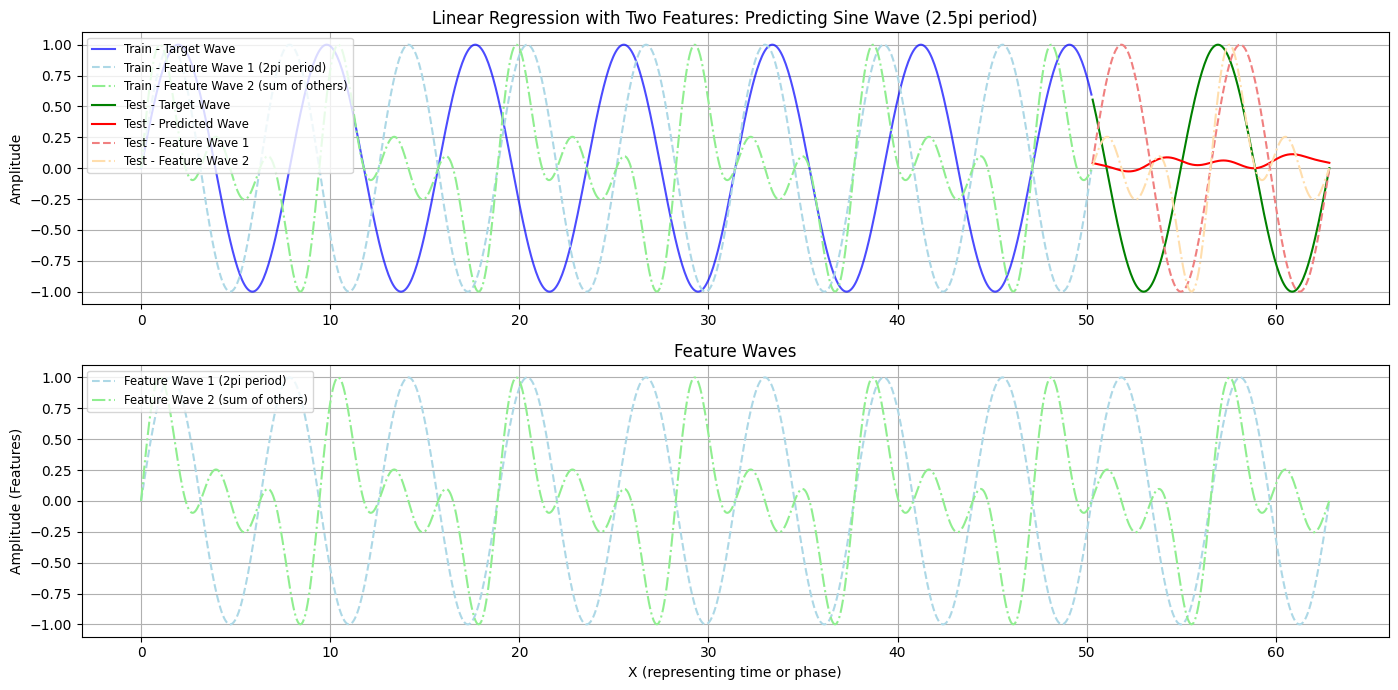

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Generate the data
period_feature1 = 2 * np.pi
period_target = 2.5 * np.pi
num_wavelengths = 10
points_per_wavelength = 100
total_points = num_wavelengths * points_per_wavelength

x = np.linspace(0, num_wavelengths * period_feature1, total_points)

# Generate feature sine wave 1 (period 2pi)
feature_wave1 = np.sin(2 * np.pi * x / period_feature1)

# Generate feature wave 2 (sum of random-ish wavelengths, not 2.5pi)
periods_feature2_components = [np.pi, 1.5 * np.pi, 3 * np.pi] # Periods for component waves
feature_wave2 = np.zeros_like(x) # Initialize feature_wave2
for period in periods_feature2_components:
    feature_wave2 += np.sin(2 * np.pi * x / period)

# Normalize feature_wave2 to have a similar amplitude range to feature_wave1 (optional but can be helpful for linear regression)
feature_wave2 = feature_wave2 / np.max(np.abs(feature_wave2))

# Generate target sine wave (period 2.5pi)
target_wave = np.sin(2 * np.pi * x / period_target)

# 2. Prepare data for regression
X = np.column_stack((feature_wave1, feature_wave2)) # Stack features horizontally to create 2-feature X
y = target_wave

# 3. Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * total_points)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# 4. Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"R-squared on Test Set: {r2:.4f}")

# 7. Visualize the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1) # Top subplot for waves
plt.plot(x[:train_size], y_train, label='Train - Target Wave', color='blue', alpha=0.7)
plt.plot(x[:train_size], X_train[:, 0], label='Train - Feature Wave 1 (2pi period)', color='lightblue', linestyle='--')
plt.plot(x[:train_size], X_train[:, 1], label='Train - Feature Wave 2 (sum of others)', color='lightgreen', linestyle='-.')
plt.plot(x[train_size:], y_test, label='Test - Target Wave', color='green')
plt.plot(x[train_size:], y_pred, label='Test - Predicted Wave', color='red', linestyle='-')
plt.plot(x[train_size:], X_test[:, 0], label='Test - Feature Wave 1', color='lightcoral', linestyle='--')
plt.plot(x[train_size:], X_test[:, 1], label='Test - Feature Wave 2', color='navajowhite', linestyle='-.')


plt.ylabel('Amplitude')
plt.title('Linear Regression with Two Features: Predicting Sine Wave (2.5pi period)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)


plt.subplot(2, 1, 2) # Bottom subplot for feature waves alone (for clarity)
plt.plot(x, feature_wave1, label='Feature Wave 1 (2pi period)', color='lightblue', linestyle='--')
plt.plot(x, feature_wave2, label='Feature Wave 2 (sum of others)', color='lightgreen', linestyle='-.')
plt.xlabel('X (representing time or phase)')
plt.ylabel('Amplitude (Features)')
plt.title('Feature Waves')
plt.legend(loc=2, fontsize='small')
plt.grid(True)


plt.tight_layout()
plt.show()

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # For feature scaling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_nn_model(input_shape):
    """
    Creates a simple neural network model for regression.

    Parameters:
    input_shape (int): The shape of the input data (number of features).

    Returns:
    keras.Sequential: A compiled Keras Sequential model.
    """
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)), # Input layer, explicitly define input shape
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)), # Hidden layer 1, 64 neurons, ReLU activation
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)), # Hidden layer 2, 32 neurons, ReLU activation
        layers.Dropout(0.2),
        layers.Dense(1)                       # Output layer, 1 neuron for regression (linear activation by default)
    ])
    return model

def train_and_evaluate_nn(X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    """
    Trains and evaluates a neural network model for regression.

    Parameters:
    X_train, y_train, X_test, y_test: Training and testing data (NumPy arrays).
    epochs (int): Number of training epochs.
    batch_size (int): Batch size for training.

    Returns:
    tuple: (keras.Sequential model, y_pred_nn, mse_nn, r2_nn) - trained model, predictions, MSE, R-squared.
    """
    input_shape = X_train.shape[1] # Get the number of features from training data
    model_nn = create_nn_model(input_shape)

    # Compile the model
    model_nn.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae']) # Using MSE as loss, and MSE, MAE as metrics

    # Train the model
    history = model_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1) # Reduced verbosity

    # Evaluate on test set
    loss_nn, mse_nn, mae_nn = model_nn.evaluate(X_test, y_test, verbose=1) # Reduced verbosity
    print(f"Neural Network - Mean Squared Error on Test Set: {mse_nn:.4f}")
    print(f"Neural Network - Mean Absolute Error on Test Set: {mae_nn:.4f}")

    # Make predictions
    y_pred_nn = model_nn.predict(X_test).flatten() # Flatten predictions to 1D array

    # Calculate R-squared
    r2_nn = r2_score(y_test, y_pred_nn)
    print(f"Neural Network - R-squared on Test Set: {r2_nn:.4f}")

    return model_nn, y_pred_nn, mse_nn, r2_nn, history



# --- Example Usage (replace with your actual data loading and preprocessing) ---
# Assuming you have a DataFrame 'df_transformed_angles' with angle columns
# and 'Monthly_Sunspot_Number' column.

# 1. Prepare Data
feature_columns_nn = [f"{p1}-{p2}-cos" for p1, p2 in planet_pairs] + [f"{p}-galactic_center-cos" for p in planets] + \
       [f"{p1}-{p2}-sin" for p1, p2 in planet_pairs] + [f"{p}-galactic_center-sin" for p in planets]
target_column_nn = 'Sunspot_Number_smoothed_13m'
# start_index = 37254   # 1920 start
start_index = 11688     # 1850 start
end_index = 75513     # end of confirmed data

# X_nn = df_with_trig[start_index:end_index][feature_columns_nn].fillna(df_transformed_angles[feature_columns_nn].mean()).values # Handle NaNs, convert to numpy array
X_nn = df_with_trig[start_index:end_index][feature_columns_nn].values # Handle NaNs, convert to numpy array
y_nn = df_with_trig[start_index:end_index][target_column_nn].values

# 2. Feature Scaling (important for Neural Networks)
scaler_nn = StandardScaler()
X_scaled_nn = scaler_nn.fit_transform(X_nn)

# 3. Time-based Train/Test Split (same split point as before for comparison)
train_size_nn = int(0.8 * len(X_scaled_nn)) # Example: 80% train
X_train_nn = X_scaled_nn[:train_size_nn]
X_test_nn = X_scaled_nn[train_size_nn:]
y_train_nn = y_nn[:train_size_nn]
y_test_nn = y_nn[train_size_nn:]

# 4. Train and Evaluate Neural Network
model_nn, y_pred_nn, mse_nn, r2_nn, history_nn = train_and_evaluate_nn(X_train_nn, y_train_nn, X_test_nn, y_test_nn, epochs=200, batch_size=16) # Increased epochs

Epoch 1/200
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2710.3523 - mae: 36.8637 - mse: 2707.1985 - val_loss: 6536.3755 - val_mae: 69.9712 - val_mse: 6531.9829
Epoch 2/200
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 248.3472 - mae: 11.4165 - mse: 243.8237 - val_loss: 6615.1157 - val_mae: 69.9096 - val_mse: 6610.3501
Epoch 3/200
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 196.7122 - mae: 9.9758 - mse: 191.8977 - val_loss: 6842.2886 - val_mae: 70.9582 - val_mse: 6837.3135
Epoch 4/200
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 182.6708 - mae: 9.4763 - mse: 177.6740 - val_loss: 6588.7280 - val_mae: 69.8729 - val_mse: 6583.6973
Epoch 5/200
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 165.5882 - mae: 8.8956 - mse: 160.5334 - val_loss: 6782.5874 - val_mae: 70.6207 - val_mse: 6777.4902
Epoch 6/200
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 163.0654 - mae: 8.8045 - mse: 157.9715 - val_loss: 6864.7905 - val_mae: 70.4846 - val_mse: 6859.6646
Epoch 7/200


2546/2546 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step


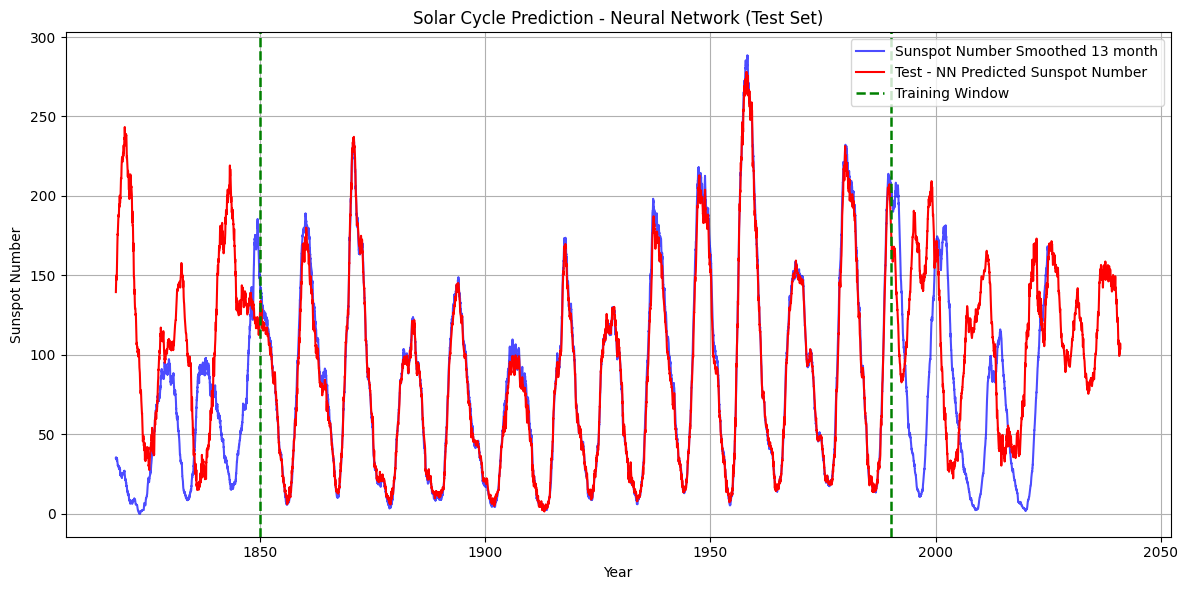

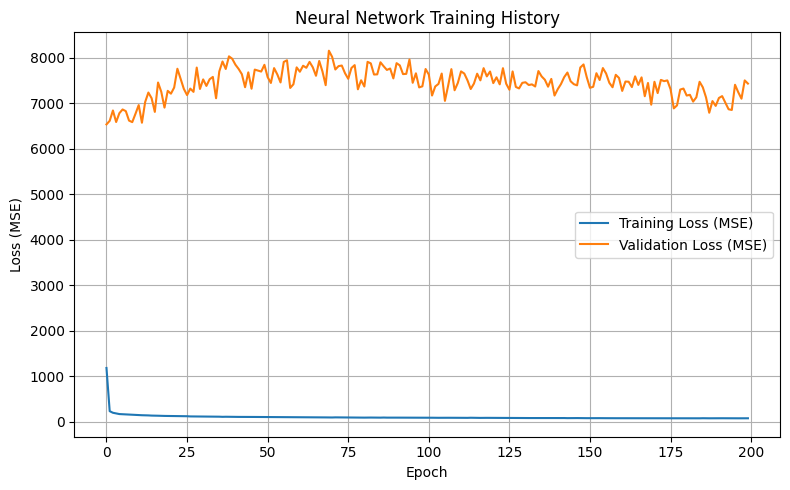

In [420]:
# 5. Visualize Results (Neural Network Predictions)

start_index = 11688     # 1850 start
end_index = 75513
df_with_trig_restricted = df_with_trig[start_index:end_index]

plt.figure(figsize=(12, 6))
plt.plot(df_with_trig['Decimal_Year'], df_with_trig['Sunspot_Number_smoothed_13m'], label='Sunspot Number Smoothed 13 month', color='blue', alpha=0.7)
# plt.plot(df_with_trig_restricted['Decimal_Year'][train_size_nn:], y_test_nn, label='Test - Actual Sunspot Number', color='green')
# plt.plot(df_with_trig_restricted['Decimal_Year'][train_size_nn:], y_pred_nn, label='Test - NN Predicted Sunspot Number', color='red', linestyle='-')
plt.plot(df_with_trig['Decimal_Year'], model_nn.predict(scaler_nn.fit_transform(df_with_trig[feature_columns_nn].values)), label='Test - NN Predicted Sunspot Number', color='red', linestyle='-')
plt.axvline(x=1850.001, color='g', linestyle='--', linewidth=1.8, label='Training Window')
plt.axvline(x=1990.001, color='g', linestyle='--', linewidth=1.8)

plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Solar Cycle Prediction - Neural Network (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('NN prediction.png')
plt.show()

# (Optional) Plot Training History (Loss)
plt.figure(figsize=(8, 5))
plt.plot(history_nn.history['loss'], label='Training Loss (MSE)')
plt.plot(history_nn.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

30607
50839
30607
7652
7652


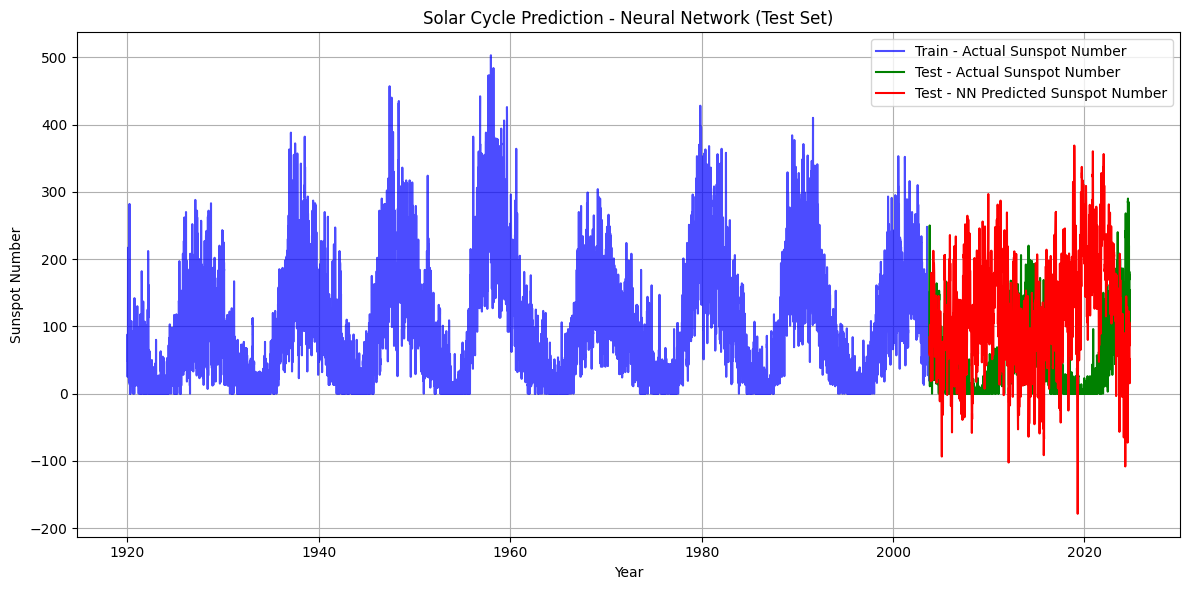

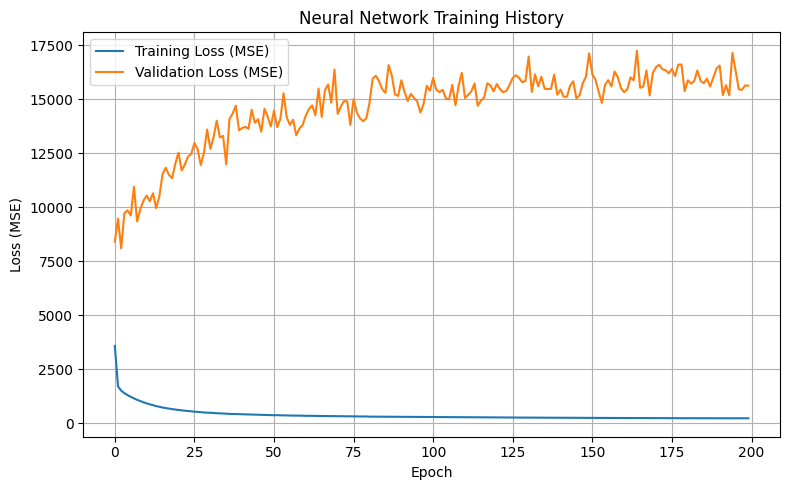

In [327]:
# 5. Visualize Results (Neural Network Predictions)

df_with_trig_restricted = df_with_trig[start_index:end_index]

plt.figure(figsize=(12, 6))
plt.plot(df_with_trig_restricted['Decimal_Year'][:train_size_nn], y_train_nn, label='Train - Actual Sunspot Number', color='blue', alpha=0.7)
plt.plot(df_with_trig_restricted['Decimal_Year'][train_size_nn:], y_test_nn, label='Test - Actual Sunspot Number', color='green')
plt.plot(df_with_trig_restricted['Decimal_Year'][train_size_nn:], y_pred_nn, label='Test - NN Predicted Sunspot Number', color='red', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Solar Cycle Prediction - Neural Network (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (Optional) Plot Training History (Loss)
plt.figure(figsize=(8, 5))
plt.plot(history_nn.history['loss'], label='Training Loss (MSE)')
plt.plot(history_nn.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [328]:
training1 = (model_nn, y_pred_nn, mse_nn, r2_nn, history_nn)